In [2]:
import numpy as np
import polars as pl
from itertools import product
import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
def gen_binary_params(n=9):
    for bits in product([0, 1], repeat=n):
        yield np.array(bits, dtype=np.uint8)


for params in gen_binary_params(n=9):
    print("".join(map(str, params)))

000000000
000000001
000000010
000000011
000000100
000000101
000000110
000000111
000001000
000001001
000001010
000001011
000001100
000001101
000001110
000001111
000010000
000010001
000010010
000010011
000010100
000010101
000010110
000010111
000011000
000011001
000011010
000011011
000011100
000011101
000011110
000011111
000100000
000100001
000100010
000100011
000100100
000100101
000100110
000100111
000101000
000101001
000101010
000101011
000101100
000101101
000101110
000101111
000110000
000110001
000110010
000110011
000110100
000110101
000110110
000110111
000111000
000111001
000111010
000111011
000111100
000111101
000111110
000111111
001000000
001000001
001000010
001000011
001000100
001000101
001000110
001000111
001001000
001001001
001001010
001001011
001001100
001001101
001001110
001001111
001010000
001010001
001010010
001010011
001010100
001010101
001010110
001010111
001011000
001011001
001011010
001011011
001011100
001011101
001011110
001011111
001100000
001100001
001100010
001100011


| Action | C=0 | C=1 | C=2 | C=3 | C=4 |
| ------ | --- | --- | --- | --- | --- |
| C      | 0   | 6   | 12  | 18  | 24  |
| D      | 4   | 10  | 16  | 22  | 28  |


In [4]:
def get_neighbor_pos(target_pos: int, act_list: np.ndarray) -> np.ndarray:
    neighbors = []
    for i in range(-2, 2 + 1):
        if i == 0:
            continue
        neighbor_pos = (target_pos + i) % len(act_list)
        neighbors.append(neighbor_pos)
    return np.array(neighbors, dtype=np.uint8)


print(get_neighbor_pos(0, np.array([0, 1, 0, 1, 0, 1, 0, 1, 0])))
print(get_neighbor_pos(1, np.array([0, 1, 0, 1, 0, 1, 0, 1, 0])))
print(get_neighbor_pos(4, np.array([0, 1, 0, 1, 0, 1, 0, 1, 0])))
print(get_neighbor_pos(8, np.array([0, 1, 0, 1, 0, 1, 0, 1, 0])))

[7 8 1 2]
[8 0 2 3]
[2 3 5 6]
[6 7 0 1]


In [5]:
def get_neighbor_actions(target_pos: int, act_list: np.ndarray) -> np.ndarray:
    neighbors = get_neighbor_pos(target_pos, act_list)
    return act_list[neighbors]


print(get_neighbor_actions(0, np.array([0, 1, 0, 1, 0, 1, 0, 1, 0])))
print(get_neighbor_actions(1, np.array([0, 1, 0, 1, 0, 1, 0, 1, 0])))
print(get_neighbor_actions(4, np.array([0, 1, 0, 1, 0, 1, 0, 1, 0])))
print(get_neighbor_actions(8, np.array([0, 1, 0, 1, 0, 1, 0, 1, 0])))

[1 0 1 0]
[0 0 0 1]
[0 1 1 0]
[0 1 0 1]


In [6]:
def calculate_payoff(target_pos: int, act_list: np.ndarray, bc_ratio: int = 6):
    nei_acts = get_neighbor_actions(target_pos, act_list)
    coop_num = np.sum(nei_acts)
    defect_benefit = (1 - act_list[target_pos]) * 4

    return coop_num * bc_ratio + defect_benefit


test_cases = [
    {"test_pos": 0, "test_act": np.array([1, 0, 1, 0, 1, 0, 1, 0, 1]), "expected": 12},
    {"test_pos": 1, "test_act": np.array([1, 0, 1, 0, 1, 0, 1, 0, 1]), "expected": 22},
    {"test_pos": 2, "test_act": np.array([1, 0, 1, 1, 1, 0, 1, 0, 1]), "expected": 18},
    {"test_pos": 3, "test_act": np.array([1, 1, 1, 0, 1, 1, 1, 0, 1]), "expected": 28},
    {"test_pos": 7, "test_act": np.array([1, 0, 1, 0, 1, 0, 1, 0, 1]), "expected": 22},
    {"test_pos": 8, "test_act": np.array([1, 0, 1, 0, 1, 0, 1, 0, 0]), "expected": 16},
]
for test_case in test_cases:
    res_payoff = calculate_payoff(test_case["test_pos"], test_case["test_act"])
    assert (
        res_payoff == test_case["expected"]
    ), f"Test failed: expected {test_case['expected']}, got {res_payoff}"

In [7]:
def calc_payoff_list(act_list: np.ndarray, bc_ratio: int = 6) -> np.ndarray:
    payoffs = np.zeros(len(act_list), dtype=np.int32)
    for i in range(len(act_list)):
        payoffs[i] = calculate_payoff(i, act_list, bc_ratio)
    return np.array(payoffs, dtype=np.int32)


test_cases = [
    {"test_act": np.array([1, 0, 1, 0, 1, 0, 1, 0, 1])},
    {"test_act": np.array([1, 0, 1, 1, 1, 0, 1, 0, 1])},
]
for test_case in test_cases:
    res_payoffs = calc_payoff_list(test_case["test_act"])
    print(test_case["test_act"])
    print(res_payoffs)

[1 0 1 0 1 0 1 0 1]
[12 22 12 16 12 16 12 22 12]
[1 0 1 1 1 0 1 0 1]
[12 28 18 12 18 22 12 22 12]


In [8]:
def get_highest_action(act_list: np.ndarray, pos: int = 4) -> int:
    payoffs = calc_payoff_list(act_list)
    nei_pos = get_neighbor_pos(pos, act_list)
    nei_payoffs = payoffs[nei_pos]
    highest_nei_payoff = np.max(nei_payoffs)
    target_payoff = payoffs[pos]

    if target_payoff >= highest_nei_payoff:
        return act_list[pos]
    else:
        return act_list[nei_pos[np.argmax(nei_payoffs)]]


test_cases = [
    {"test_act": np.array([1, 0, 1, 0, 1, 0, 1, 0, 1])},
    {"test_act": np.array([1, 1, 1, 1, 1, 0, 1, 0, 1])},
]
for test_case in test_cases:
    res_highest_act = get_highest_action(test_case["test_act"])
    print(test_case["test_act"])
    print(res_highest_act)

[1 0 1 0 1 0 1 0 1]
0
[1 1 1 1 1 0 1 0 1]
1


In [9]:
res_highest_act = np.zeros(2**9, dtype=np.uint8)
for i, act in enumerate(gen_binary_params(n=9)):
    res_highest_act[i] = get_highest_action(act, pos=4)
print(res_highest_act)
print(res_highest_act.mean())

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 1 0 0 0 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 0 0 0 0 0 1 1 1 0 1 1 1 1 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1
 0 0 0 0 0 0 1 0 0 0 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1
 1 1 1 0 0 0 0 0 0 0 0 0 

In [10]:
N = 9
res_highest_act_df = np.zeros((2**N, N + 2), dtype=np.float16)
highest_act_list = np.zeros(2**N, dtype=np.uint8)
for i, act in enumerate(gen_binary_params(n=N)):
    res_highest_act_df[i, :-2] = act
    highest_act = get_highest_action(act, pos=4)
    res_highest_act_df[i, -2] = highest_act
    res_highest_act_df[i, -1] = get_neighbor_actions(4, act).mean()

    highest_act_list[i] = highest_act

print(res_highest_act_df.shape)
print(res_highest_act_df)
# print(res_highest_act_df[:, -1])
print(highest_act_list.mean())

(512, 11)
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 1. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [1. 1. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 0. 1. 1.]
 [1. 1. 1. ... 1. 1. 1.]]
0.1171875


In [11]:
df = pl.DataFrame(
    {
        "pos0_act": [int(x) for x in res_highest_act_df[:, 0]],
        "pos1_act": [int(x) for x in res_highest_act_df[:, 1]],
        "pos2_act": [int(x) for x in res_highest_act_df[:, 2]],
        "pos3_act": [int(x) for x in res_highest_act_df[:, 3]],
        "pos4_act": [int(x) for x in res_highest_act_df[:, 4]],
        "pos5_act": [int(x) for x in res_highest_act_df[:, 5]],
        "pos6_act": [int(x) for x in res_highest_act_df[:, 6]],
        "pos7_act": [int(x) for x in res_highest_act_df[:, 7]],
        "pos8_act": [int(x) for x in res_highest_act_df[:, 8]],
        "highest_action": [int(x) for x in res_highest_act_df[:, 9]],
        "nei_coop": res_highest_act_df[:, 10].astype(np.float16),
    }
).with_columns(pl.col("pos4_act").alias("my_action"))
df.head()

pos0_act,pos1_act,pos2_act,pos3_act,pos4_act,pos5_act,pos6_act,pos7_act,pos8_act,highest_action,nei_coop,my_action
i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,f32,i64
0,0,0,0,0,0,0,0,0,0,0.0,0
0,0,0,0,0,0,0,0,1,0,0.0,0
0,0,0,0,0,0,0,1,0,0,0.0,0
0,0,0,0,0,0,0,1,1,0,0.0,0
0,0,0,0,0,0,1,0,0,0,0.25,0


shape: (10, 3)
┌──────────┬───────────┬─────────────────────┐
│ nei_coop ┆ my_action ┆ mean_highest_action │
│ ---      ┆ ---       ┆ ---                 │
│ f32      ┆ i64       ┆ f64                 │
╞══════════╪═══════════╪═════════════════════╡
│ 0.0      ┆ 0         ┆ 0.0                 │
│ 0.25     ┆ 0         ┆ 0.0                 │
│ 0.5      ┆ 0         ┆ 0.083333            │
│ 0.75     ┆ 0         ┆ 0.0                 │
│ 1.0      ┆ 0         ┆ 0.0                 │
│ 0.0      ┆ 1         ┆ 0.0                 │
│ 0.25     ┆ 1         ┆ 0.0                 │
│ 0.5      ┆ 1         ┆ 0.166667            │
│ 0.75     ┆ 1         ┆ 0.3125              │
│ 1.0      ┆ 1         ┆ 1.0                 │
└──────────┴───────────┴─────────────────────┘


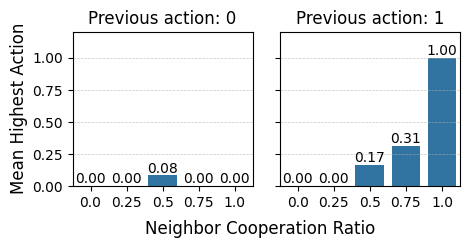

In [19]:
# coop_ratio と highest_action との関連
summary_df = (
    df.group_by("nei_coop", "my_action")
    .agg(
        pl.col("highest_action").mean().alias("mean_highest_action"),
    )
    .sort(
        "my_action",
        "nei_coop",
    )
)
print(summary_df)

fig, axes = plt.subplots(1, 2, figsize=(5, 2))
fig.subplots_adjust(wspace=0.15)
fig.supxlabel("Neighbor Cooperation Ratio", y=-0.15)
fig.supylabel("Mean Highest Action", x=-0.0)

colors = sns.color_palette("tab10", n_colors=4)
for i, ax in enumerate(axes):
    sns.barplot(
        data=summary_df.filter(pl.col("my_action") == i).to_pandas(),
        x="nei_coop",
        y="mean_highest_action",
        # color=colors[i + 2],
        color=colors[0],
        ax=ax,
    )
    ax.set_title(f"Previous action: {i}")
    ax.set_xlabel("")
    ax.set_ylabel("")

    ax.set_yticks(np.arange(0, 1.1, 0.25))
    ax.set_ylim(0, 1.2)
    ax.grid(axis="y", linestyle="--", linewidth=0.5, alpha=0.7)

    for container in ax.containers:
        ax.bar_label(container, fmt="%.2f")  # fmt で小数点以下の桁数を指定

    if i == 1:
        ax.set_yticklabels([])
        ax.set_ylabel("")

shape: (10, 3)
┌──────────┬───────────┬─────────────────────┐
│ nei_coop ┆ my_action ┆ mean_highest_action │
│ ---      ┆ ---       ┆ ---                 │
│ f32      ┆ i64       ┆ f64                 │
╞══════════╪═══════════╪═════════════════════╡
│ 0.0      ┆ 0         ┆ 0.0                 │
│ 0.0      ┆ 1         ┆ 0.0                 │
│ 0.25     ┆ 0         ┆ 0.0                 │
│ 0.25     ┆ 1         ┆ 0.0                 │
│ 0.5      ┆ 0         ┆ 0.083333            │
│ 0.5      ┆ 1         ┆ 0.166667            │
│ 0.75     ┆ 0         ┆ 0.0                 │
│ 0.75     ┆ 1         ┆ 0.3125              │
│ 1.0      ┆ 0         ┆ 0.0                 │
│ 1.0      ┆ 1         ┆ 1.0                 │
└──────────┴───────────┴─────────────────────┘


<Axes: xlabel='nei_coop', ylabel='mean_highest_action'>

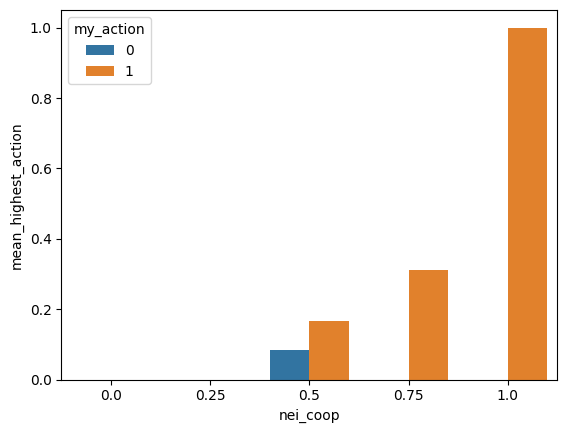

In [13]:
# coop_ratio と highest_action との関連
summary_df = (
    df.group_by("nei_coop", "my_action")
    .agg(
        pl.col("highest_action").mean().alias("mean_highest_action"),
    )
    .sort("nei_coop", "my_action")
)
print(summary_df)
sns.barplot(
    data=summary_df.to_pandas(),
    x="nei_coop",
    y="mean_highest_action",
    hue="my_action",
)

In [14]:
# highest_action が 1 である割合
highest_coop_df = df.filter(pl.col("highest_action") == 1)
print(highest_coop_df.head())
print((highest_coop_df.shape[0] / df.shape[0]) * 100, "%")

shape: (5, 12)
┌──────────┬──────────┬──────────┬──────────┬───┬──────────┬────────────────┬──────────┬───────────┐
│ pos0_act ┆ pos1_act ┆ pos2_act ┆ pos3_act ┆ … ┆ pos8_act ┆ highest_action ┆ nei_coop ┆ my_action │
│ ---      ┆ ---      ┆ ---      ┆ ---      ┆   ┆ ---      ┆ ---            ┆ ---      ┆ ---       │
│ i64      ┆ i64      ┆ i64      ┆ i64      ┆   ┆ i64      ┆ i64            ┆ f32      ┆ i64       │
╞══════════╪══════════╪══════════╪══════════╪═══╪══════════╪════════════════╪══════════╪═══════════╡
│ 0        ┆ 0        ┆ 0        ┆ 0        ┆ … ┆ 1        ┆ 1              ┆ 0.5      ┆ 0         │
│ 0        ┆ 0        ┆ 0        ┆ 0        ┆ … ┆ 1        ┆ 1              ┆ 0.5      ┆ 1         │
│ 0        ┆ 0        ┆ 0        ┆ 0        ┆ … ┆ 0        ┆ 1              ┆ 0.5      ┆ 1         │
│ 0        ┆ 0        ┆ 0        ┆ 0        ┆ … ┆ 1        ┆ 1              ┆ 0.5      ┆ 1         │
│ 0        ┆ 0        ┆ 0        ┆ 1        ┆ … ┆ 0        ┆ 1              

In [15]:
# highest_action が 1 で，前回自分が 非協力 した場合の割合
defect_df = df.filter(pl.col("highest_action") == 1).filter(pl.col("pos4_act") == 0)
print((defect_df.shape[0] / df.shape[0]) * 100, "%")

# P(highest_action = 1 | pos4_act = 0)
print((defect_df.shape[0] / df.filter(pl.col("pos4_act") == 0).shape[0]) * 100, "%")

1.5625 %
3.125 %
